In [1]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

from cuqipy_cil.model import ParallelBeam2DModel, FanBeam2DModel
import cuqipy_cil

# Load dataset from HTC 2022

Load sinogram and acquisition data

In [2]:
mat = scipy.io.loadmat("htc2022_tb_full.mat")
sinogram = mat['CtDataFull'][0][0][1].astype('float32')
sinogram = sinogram[::2,:]
num_angles = sinogram.shape[0]
num_dets = sinogram.shape[1]
source_center = 410.66
source_detector = 553.74
det_pixel_size = 0.2
angles = np.linspace(0,2*np.pi,num_angles,endpoint=True)
mag = source_detector / source_center
m = num_angles*num_dets

# Setup CT Problem

To setup and solve a CT problem we need a forward model and a dataset. 

#### CT Model
The CT forward model can be setup convinently with the cil-plugin to cuqipy. 

In [3]:
# Define CT model conveniently with cil-plugin
N = 500
n = N**2

model = FanBeam2DModel(det_count=num_dets, 
                        det_spacing = det_pixel_size,
                        angles=-angles,
                        source_object_dist = source_center,
                        object_detector_dist = source_detector - source_center,
                        domain = (det_pixel_size*num_dets/mag, det_pixel_size*num_dets/mag),
                        im_size = (N,N)) 

print(model)

CUQI FanBeam2DModel: Image2D(250000,) -> Image2D(202160,). Forward parameters: ['x']



#### Dataset

We use a dataset from HTC 2022. It is available at https://zenodo.org/record/6937616#.YzrjoGdBybg and described at https://www.fips.fi/HTCdata.php#anchor1. 
The dataset was loaded above, and below we wrap it in CUQI geometry:

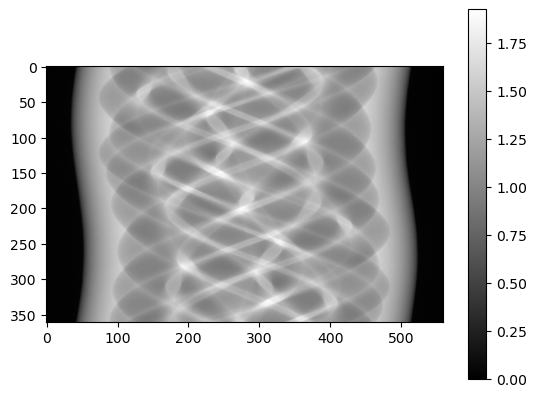

In [4]:
# It is not so easy to know how cuqi would like the sinograms order/geometry
data = cuqi.samples.CUQIarray(sinogram.flatten(order="C"), is_par=True, geometry=cuqi.geometry.Image2D((num_angles, num_dets)))
data.plot()
plt.colorbar()

For Bayesian inversion we must define the data distribution. Below the data distribution is defined assuming data precision $\lambda$:

In [5]:
# Define data/noise distribution
λ_est = 10000
data_dist  = cuqi.distribution.GaussianCov(model, 1/λ_est, geometry=model.range_geometry)

# Simple Bayesian Problem with Gaussian distributions and fast sampling

First we illustrate a simple Bayesian problem where the linear CT model and Gaussian posterior allows fast sampling with Linear-RTO. 

#### Setup Bayesian Problem and sampler

In [6]:
# Gaussian Prior
δ_est = 100
prior = cuqi.distribution.GaussianCov(np.zeros(n), 1/δ_est, geometry=model.domain_geometry)

# Gaussian likelihood function (see data distribution)
likelihood = data_dist.to_likelihood(data)

# Posterior distribution
posterior = cuqi.distribution.Posterior(likelihood, prior)

# Setup sampler
sampler = cuqi.sampler.Linear_RTO(posterior)

# What about MAP? Easy way with cuqipy?

#### Run sampling

In [7]:
# Run sampler
st = time.time()
samples = sampler.sample(500,100)
et = time.time()-st
print("Time: {}".format(et))

Sample 600 / 600
Time: 422.25659680366516


#### Plot posterior samples and statistics

Plotting 5 randomly selected samples


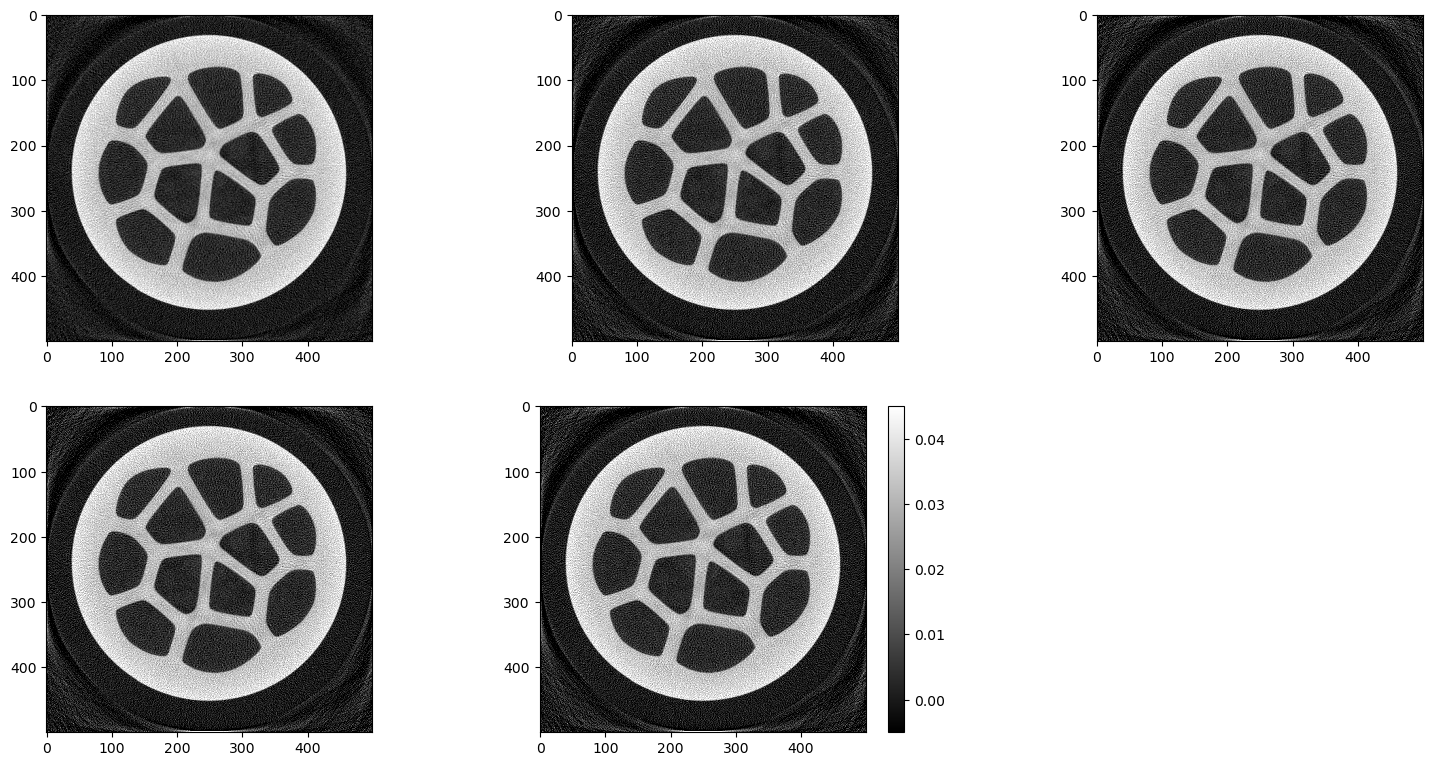

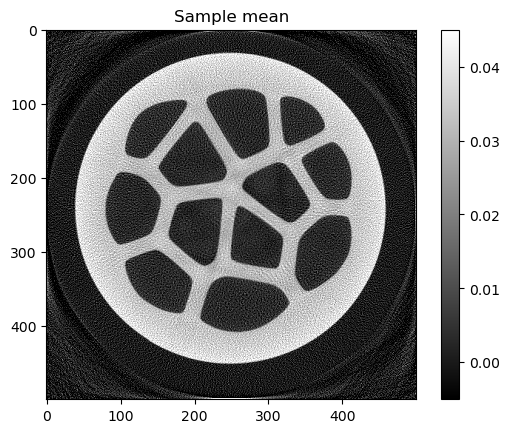

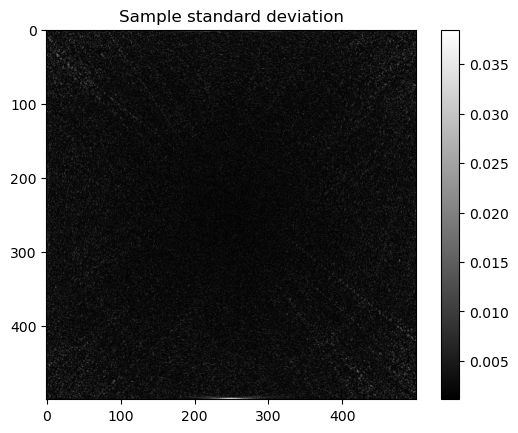

In [9]:
# Plot posterior samples
plt.figure()
samples.plot(vmin = -0.005, vmax = 0.045)
plt.colorbar()

#Plot mean
plt.figure()
samples.plot_mean(vmin = -0.005, vmax = 0.045)
plt.colorbar()

# Plot std
plt.figure()
samples.plot_std()
plt.colorbar()

# Edge-preserving Prior

#### Setup Prior and sampler

In [10]:
# Gaussian Prior
δ_est_TV = 100
prior_TV = cuqi.distribution.Laplace_diff(np.zeros(n), 1/δ_est_TV, bc_type="zero", physical_dim=2, geometry=model.domain_geometry)

# Posterior distribution
posterior_TV = cuqi.distribution.Posterior(likelihood, prior_TV)

# Setup sampler
sampler_TV = cuqi.sampler.UnadjustedLaplaceApproximation(posterior_TV)

#### Run sampling

In [11]:
# Run sampler
st = time.time()
samples_TV = sampler_TV.sample(500,100)
et = time.time()-st
print("Time: {}".format(et))

Sample 600 / 600
Time: 1742.1406388282776


#### Posterior samples and statistics

Plotting 5 randomly selected samples


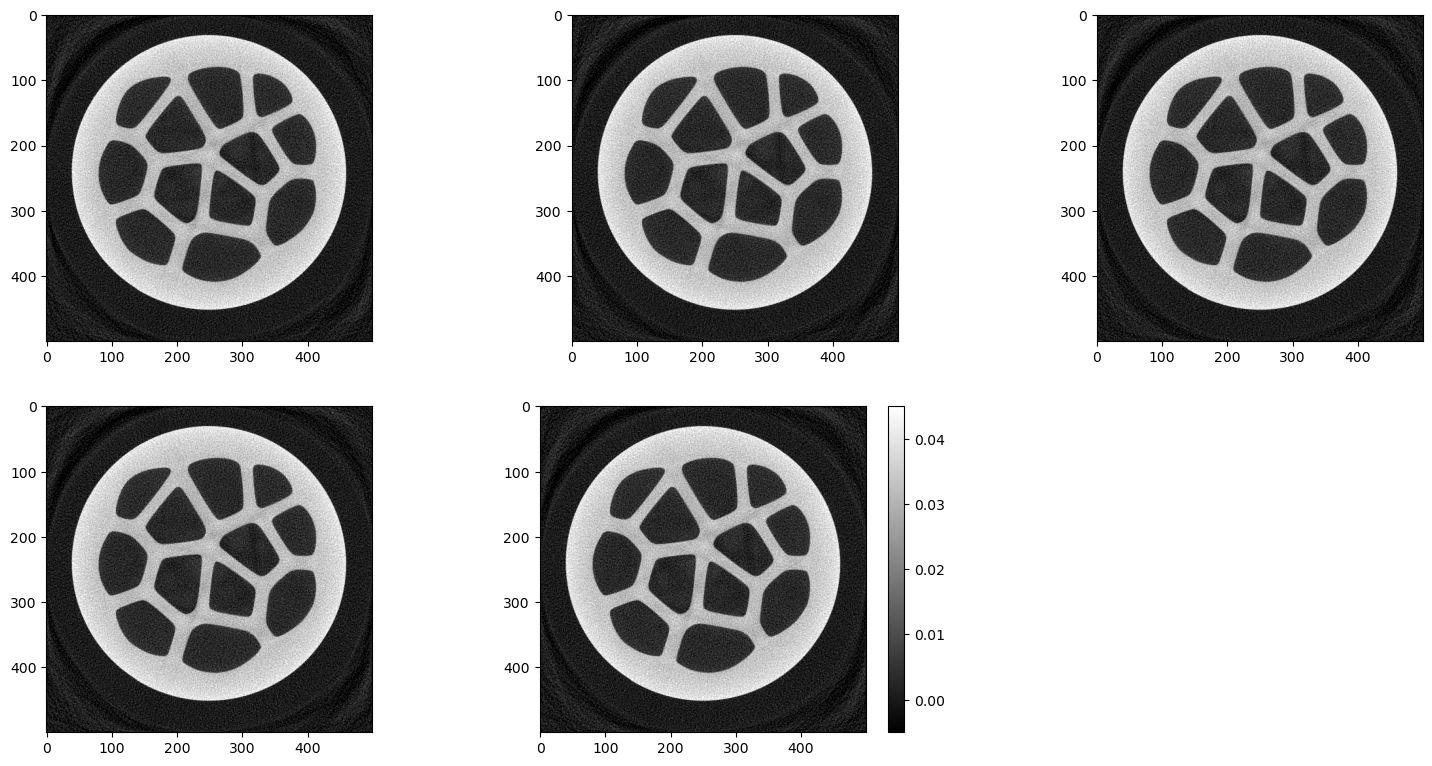

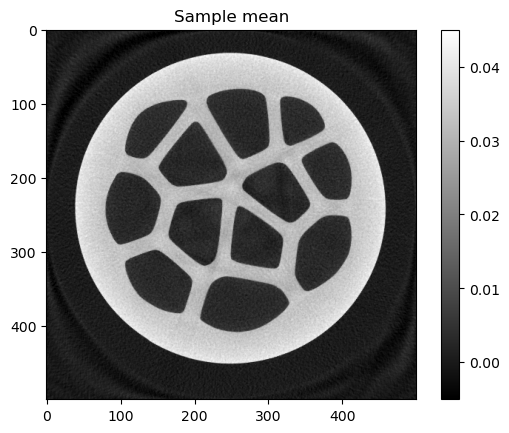

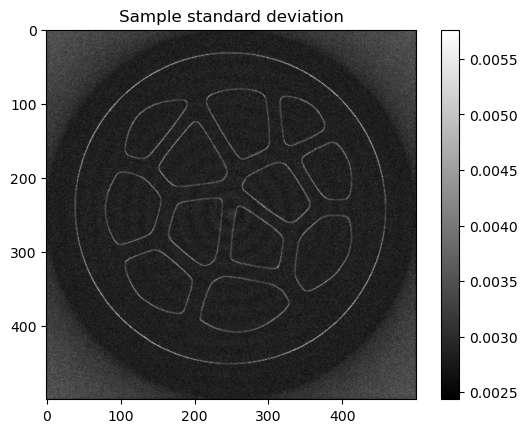

In [13]:
# Plot posterior samples
plt.figure()
samples_TV.plot(vmin = -0.005, vmax = 0.045)
plt.colorbar()

#Plot mean
plt.figure()
samples_TV.plot_mean(vmin = -0.005, vmax = 0.045)
plt.colorbar()

# Plot std
plt.figure()
samples_TV.plot_std()
plt.colorbar()

# Unknown noise and regularization parameters

If we do not know the noise level and/or the regularization level we can include these parameters as unknowns in the Bayesian Problem. This makes a so-called hierachical problem and can be solved in a Gibbs scheme. The Gibbs sampler uses conditional distributions which are derived from the joint distribution of the likelihood, prior and hyper-priors. We choose Gamma hyper-priors because of conjugacy.

#### Setup hierachical problem and sampler

In [14]:
class UGLA(cuqi.sampler.UnadjustedLaplaceApproximation):

    def step(self, x):
        self.x0 = x
        return self.sample(2).samples[:,-1]

In [21]:
# Data distribution (Likelihood)
y = cuqi.distribution.GaussianCov(mean=model, cov=lambda λ: 1/λ, name="y", geometry=model.range_geometry)

# Priors
x = cuqi.distribution.Laplace_diff(location=np.zeros(model.domain_dim), scale=lambda δ: 1/δ, bc_type="zero", physical_dim=2, geometry=model.domain_geometry, name="x")
λ = cuqi.distribution.Gamma(shape=1, rate=1e-4, name="λ")
δ = cuqi.distribution.Gamma(shape=1, rate=1e-4, name="δ")

# Define joint distribution p(y,x,λ,δ) = p(y|x,λ)p(x|δ)p(λ)p(δ)
P = cuqi.distribution.JointDistribution(y, x, λ, δ)

# Define posterior distribution
posterior = P(y = data)
print(posterior)

# Samplers for each parameter
sampling_strategy = {
    'x': UGLA,
    'λ': cuqi.sampler.Conjugate,
    'δ': cuqi.sampler.ConjugateApprox
}

# Gibbs sampler on p(x,λ,δ|y=y_obs)
sampler_Gibbs = cuqi.sampler.Gibbs(posterior, sampling_strategy)
#sampler_Gibbs = cuqi.sampler.Gibbs(P(y=data), {'x': UGLA, 'λ': cuqi.sampler.Conjugate, 'δ': cuqi.sampler.ConjugateApprox})

JointDistribution(
    Equation: 
	p(x,λ,δ|y) ∝ L(λ,x|y)p(x|δ)p(λ)p(δ)
    Densities: 
	y ~ CUQI GaussianCov Likelihood function. Parameters ['x', 'λ'].
	x ~ CUQI Laplace_diff. Conditioning variables ['δ'].
	λ ~ CUQI Gamma.
	δ ~ CUQI Gamma.
)


#### Run sampling

In [22]:
# Run sampler
st = time.time()
samples_Gibbs = sampler_Gibbs.sample(500,100)
et = time.time()-st
print("Time: {}".format(et))

Warmup 100 / 100
Sample 500 / 500
Time: 1579.3638780117035


#### Posterior samples and statistics

Plotting 5 randomly selected samples


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:576: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()
/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:576: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


array([[<AxesSubplot:title={'center':'δ'}>,
        <AxesSubplot:title={'center':'δ'}>]], dtype=object)

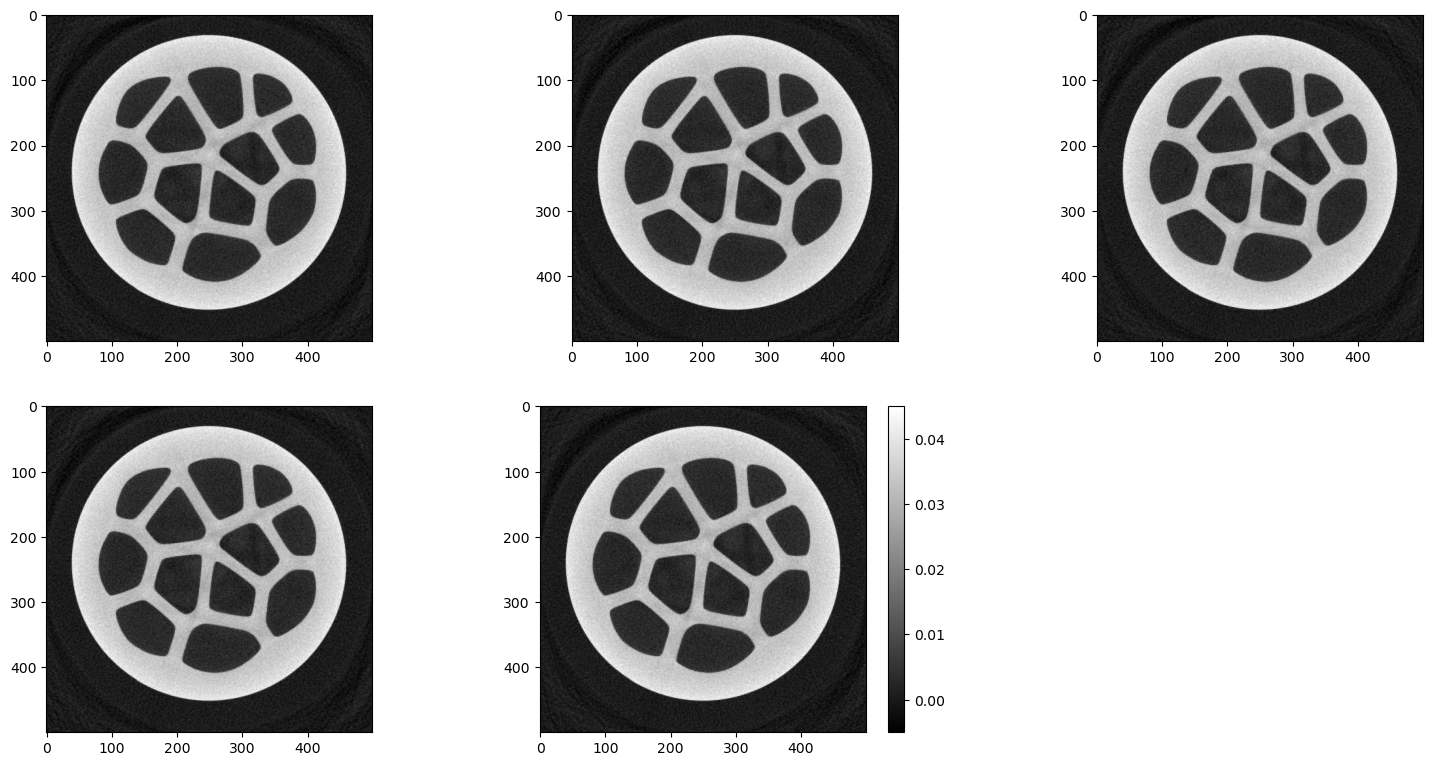

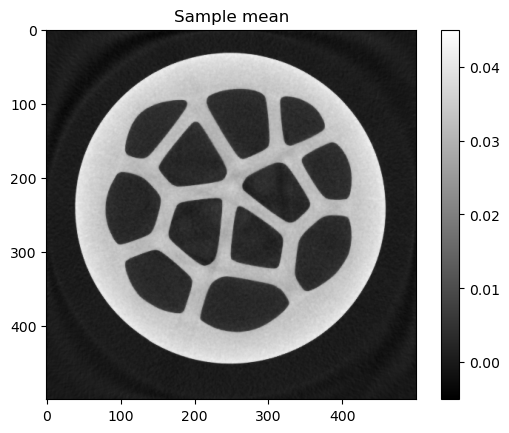

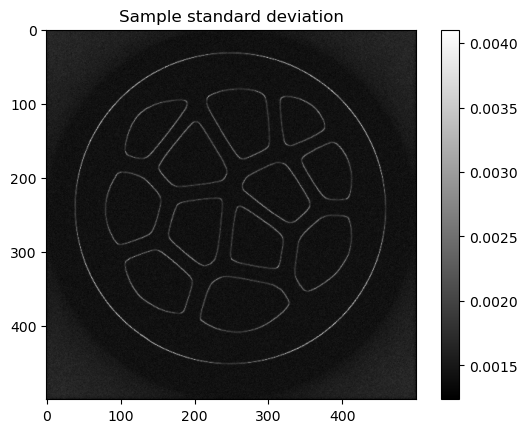

<Figure size 640x480 with 0 Axes>

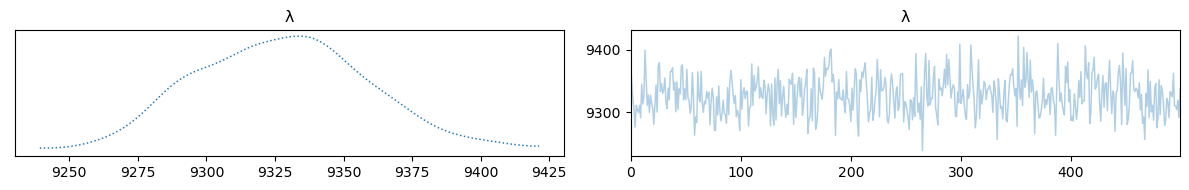

<Figure size 640x480 with 0 Axes>

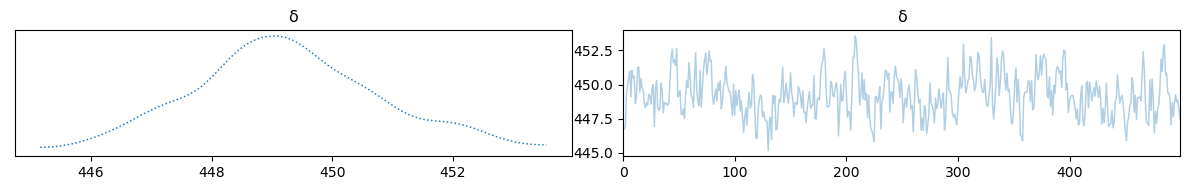

In [24]:
# Plot posterior x samples
plt.figure()
samples_Gibbs["x"].plot(vmin = -0.005, vmax = 0.045)
plt.colorbar()

# Plot x mean
plt.figure()
samples_Gibbs["x"].plot_mean(vmin = -0.005, vmax = 0.045)
plt.colorbar()

# Plot x std
plt.figure()
samples_Gibbs["x"].plot_std()
plt.colorbar()

# Plot posterior λ samples
plt.figure()
samples_Gibbs["λ"].plot_trace()

# Plot posterior δ samples
plt.figure()
samples_Gibbs["δ"].plot_trace()